exploration file for logistic regression lol

In [15]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

 - regression exploration


loaded all data in

In [157]:
closures = pd.read_csv('weather-closures-with-roads.csv')
elevation = pd.read_csv('dehradun-city-road-elevation.csv')
slope = pd.read_csv('dehradun-city-road-slope.csv')
aspect = pd.read_csv('dehradun-city-road-aspect.csv')
flood = pd.read_csv('dehradun-city-road-flood.csv')
rough = pd.read_csv('dehradun-city-road-rough.csv')

zone_id = elevation['Zone ID'] #all IDs
closure_id = closures['fid'] #all closures

In [31]:
all_roads = pd.read_csv('dehradun-city-latlon-split.csv')

generate a list of nonclosures, basically just randomly sample all of the roads that aren't marked as closed. no temporal aspect here because i don't have rain anyway, all the DEM data and road characteristics don't change.

In [158]:
nonclosures_all = zone_id[~zone_id.isin(closure_id)]
N = len(closures)
nonclosures = pd.DataFrame(nonclosures_all.sample(n=N,random_state=2))
nonclosures['fid'] = nonclosures['Zone ID']

here are some functions that make the code cleaner

In [123]:
unique = all_roads['highway'].unique()
new = []
for i in unique:
    #print(i)
    i = i.replace("[", '')
    i = i.replace("]", '')
    i = i.replace("'", '')
    i_new = i.split(', ')
    for n in i_new:
        new.append(n)

array = np.array(new)
road_set = np.unique(array)
#np.concatenate(unique)

In [203]:
def get_terrain_val(df, query_row):
    terrain_val = df.loc[df['Zone ID'] == query_row['fid']]['Maximum'].to_numpy()
    return terrain_val

def update_terrain_val(df):
    for index, row in df.iterrows():
        df.loc[index, 'elevation'] = get_terrain_val(elevation, row)
        df.loc[index, 'slope'] = get_terrain_val(slope, row)
        df.loc[index, 'aspect'] = get_terrain_val(aspect, row)
        df.loc[index, 'flood'] = get_terrain_val(flood, row)
        df.loc[index, 'rough'] = get_terrain_val(rough, row)

def get_road_val(df, query_row):
    road_val = df.loc[df['Zone ID'] == query_row['fid']]['Mean'].to_numpy()

def update_road_val(df, road_set):
    for index, row in df.iterrows():
        #road_set = all_roads['highway'].unique()
        road_id = row['fid']
        road_type = all_roads.loc[all_roads['fid'] == road_id]['highway'].to_numpy()
        df.loc[index, road_type] = 1
        road_set_new = road_set[road_set != road_type]
        df.loc[index, road_set_new] = 0

add the terrain values (elevation, slope, aspect) to the closures and nonclosures

In [204]:
update_terrain_val(closures)
update_terrain_val(nonclosures)

update_road_val(closures, road_set)
update_road_val(nonclosures, road_set)


combine closures and nonclosures into 1 table

In [211]:
closures.loc[:, 'status'] = 1
nonclosures.loc[:, 'status'] = 0
#col = ['status', 'elevation', 'slope', 'aspect', 'rough'] + road_set.tolist()
col = ['status', 'elevation', 'slope', 'aspect', 'residential']
# col.remove('path')
# col.remove('pedestrian')
# col.remove('secondary_link')
# col.remove('footway')
data = pd.concat([closures[col], nonclosures[col]])
#data.std(axis=1)
data

,status,elevation,slope,aspect,residential
0,1,604.0,4.102000,345.96378,1.0
1,1,816.0,9.052964,280.49150,0.0
2,1,642.0,9.287796,356.63354,0.0
3,1,642.0,9.287796,356.63354,0.0
4,1,669.0,5.859838,348.69006,0.0
5,1,641.0,3.384445,206.56505,0.0
6,1,619.0,5.183361,315.00000,1.0
7,1,669.0,5.859838,348.69006,0.0
8,1,669.0,2.960421,341.56506,1.0
9,1,609.0,5.544250,360.00000,0.0


In [1]:
data

NameError: name 'data' is not defined

In [212]:


y = data['status']
X = data.loc[:, data.columns != 'status']

# from sklearn.feature_selection import VarianceThreshold

# def variance_threshold_selector(data, threshold=0.5):
#     # https://stackoverflow.com/a/39813304/1956309
#     selector = VarianceThreshold(threshold)
#     selector.fit(data)
#     return data[data.columns[selector.get_support(indices=True)]]

# # min_variance = .9 * (1 - .9)  # You can play here with different values.
# min_variance = 0.001
# low_variance = variance_threshold_selector(data, min_variance) 
# print('columns removed:')
# data.columns ^ low_variance.columns
# data.shape
# data.shape
# X = low_variance


logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.293748
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.576     
Dependent Variable: status           AIC:              22.0999   
Date:               2021-08-09 18:09 BIC:              26.8121   
No. Observations:   24               Log-Likelihood:   -7.0500   
Df Model:           3                LL-Null:          -16.636   
Df Residuals:       20               LLR p-value:      0.00025200
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
elevation     -0.0158    0.0073  -2.1796  0.0293  -0.0301  -0.0016
slope          0.4810    0.3653   1.3165  0.1880  -0.2351   1.

Accuracy of logistic regression classifier on test set: 0.50


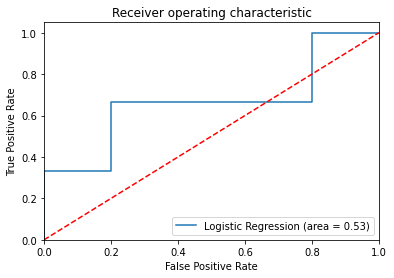

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

appendix lol

 - Make fake database of road closures
 - Assume that all closures are happening at the same time: pick that time
    - 06/29/21: 2021-06-29T16:00:00-04:00
    - 06/30/21: 2021-06-29T00:00:00-04:00
 - Pick N different locations in the same lat/lon square: between 30-31 N and 78-79 E
 - Aggregate triggering data for the past 1h and 1d
 - Put in the overall pandas dataframe
 - Run regression
 
 Hopefully, the closure data we receive should look something like this:

In [24]:
N = 20 #number of "closures"
time = pd.DataFrame(['2021-06-30T00:00:00-04:00'] * N)
lat_list = pd.DataFrame(np.linspace(30, 31, N))
lon_list = pd.DataFrame(np.linspace(78, 79, N))
probs = pd.DataFrame(np.random.randint(2, size=N))
closure_data = pd.concat([time, lat_list, lon_list, probs], axis=1)
closure_data.columns = ['startTime', 'Latitude', 'Longitude', 'Status']
closure_data

,startTime,Latitude,Longitude,Status
0,2021-06-30T00:00:00-04:00,30.000000,78.000000,0
1,2021-06-30T00:00:00-04:00,30.052632,78.052632,1
2,2021-06-30T00:00:00-04:00,30.105263,78.105263,0
3,2021-06-30T00:00:00-04:00,30.157895,78.157895,0
4,2021-06-30T00:00:00-04:00,30.210526,78.210526,1
5,2021-06-30T00:00:00-04:00,30.263158,78.263158,1
6,2021-06-30T00:00:00-04:00,30.315789,78.315789,1
7,2021-06-30T00:00:00-04:00,30.368421,78.368421,0
8,2021-06-30T00:00:00-04:00,30.421053,78.421053,0
9,2021-06-30T00:00:00-04:00,30.473684,78.473684,1


Next, we want to gather weather data for each location: rainfall right now, in the last 30 min, 1 hr, 3 hrs, 6 hrs, day, etc. Exact time increments can be decided later, depenidng on p-value. For illustrative purposes, we'll just do 30 min and 1 hr. 